# Retrieval-Augmented Generation: Ingestion Pipeline

## Overview
This notebook demonstrates the **ingestion** process for a Retrieval-Augmented Generation (RAG) system.  
Ingestion is the critical first stage of any RAG pipeline — it transforms raw documents into a searchable, semantically rich vector database that can be used to provide accurate, context-aware responses from an LLM.

## Steps
1. **Gather text sources** — Load documents from a file system or API
2. **Chunk documents** — Split text into overlapping, semantically meaningful segments
3. **Attach metadata** — Store attributes like author, date, and source path
4. **Generate embeddings** — Convert chunks into vector representations using an embedding model
5. **Index vectors** — Insert into a vector database for approximate nearest neighbor search

## Why It Matters
Poor ingestion = poor retrieval.  
If chunks are too large, context is lost.  
If embeddings are mismatched to the domain, results are irrelevant.  
If metadata is missing, you can’t filter precisely.  
This notebook will show how to avoid these pitfalls and build a high-quality ingestion pipeline.

### Step 1: Gathering Sources

We will be pulling text from a demo Box account, but feel free to replace this with your database of choice.

#### Box Authentication via Developer Token

In [ ]:
import requests
from boxsdk import Client, OAuth2

TOKEN_URL = 'https://api.box.com/oauth2/token'

# Fill with your credentials.
CLIENT_ID = '...'
CLIENT_SECRET = '...'
ACCESS_TOKEN = '...'


auth = OAuth2(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    access_token=ACCESS_TOKEN,
)
client = Client(auth)
me = client.user().get()
print(f'My user ID is {me.id}')


My user ID is 43951904830


#### Downloading Files from Specified Folder

In [ ]:
import zipfile
import io

# --- Folder Setup ---
# Inspect the Box folder URL: app.box.com/folder/<FOLDER_ID>
folder_id = '335468550588'  
files = client.folder(folder_id=folder_id).get_items(limit=100, offset=0)
non_text_files = ['.jpg', '.jpeg', '.csv']

# --- Load Contents into Memory ---
file_contents = {}
missed_files = []

for file in files:
    if file.type == 'file' and not file.name.endswith(tuple(non_text_files)):
        file_id = file.id
        file_name = file.name
        file_info = client.file(file_id).get()
        
        # Download file content into memory
        file_stream = client.file(file_id).content()
        file_contents[file_name] = { 'content': file_stream[0: 50000], "metadata": {} }
        for key in file_info:
            file_contents[file_name]["metadata"][key] = file_info[key]
    else:
        missed_files.append(file.name)

In [3]:
print(f"Loaded {len(file_contents)} files into memory.")
print(f"Missed {len(missed_files)} files.")

Loaded 8 files into memory.
Missed 4 files.


#### Visualization
Number of files per file type.

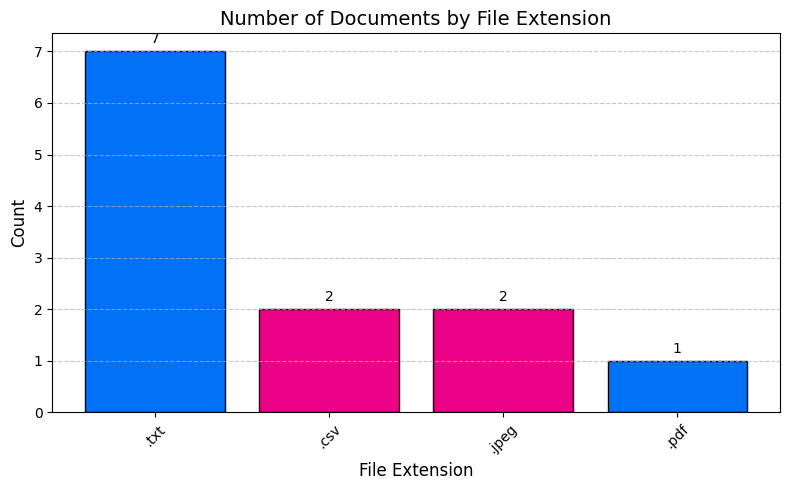

In [17]:
import matplotlib.pyplot as plt
from collections import Counter
import os

# Extract extensions from both sets
all_extensions = [os.path.splitext(name)[1].lower() for name in file_contents.keys()]
missed_extensions = [os.path.splitext(name)[1].lower() for name in missed_files]

# Count all extensions combined
ext_counts = Counter(all_extensions + missed_extensions)

# Sort by frequency
ext_counts = dict(sorted(ext_counts.items(), key=lambda x: x[1], reverse=True))

# Prepare colors: use #ec0287 (red) if extension occurs in missed files, else #0072F7 (blue)
colors = ['#ec0287' if ext in missed_extensions else '#0072F7' for ext in ext_counts.keys()]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(ext_counts.keys(), ext_counts.values(), color=colors, edgecolor='black')

plt.title("Number of Documents by File Extension", fontsize=14)
plt.xlabel("File Extension", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of bars
for i, count in enumerate(ext_counts.values()):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


### Step 2: Chunking Text

#### Functional Code

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
import random
# Initialize the splitter with desired chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

chunks = []
i = 0;
for filename in file_contents:
    # Decode bytes to string (assuming UTF-8)
    text = file_contents[filename]['content'].decode('utf-8', errors='ignore')
    
    # Split text into chunks using LangChain splitter
    file_chunks = text_splitter.split_text(text)
    for text in file_chunks:
        chunks.append({"filename": filename, "text": str(text), "id": i})
        i += 1;

In [6]:
def random_chunk():
    return chunks[random.randint(0, len(chunks))]

In [7]:
print(f"Sample chunk text: {random_chunk()["text"]}")
print("")
print(f"Total chunks created: {len(chunks)} from {len(file_contents)} files.")

Sample chunk text: . <p> " We are good friends and I understand the way he is , " Nelson said . " He has never been outgoing . I 've always respected his wishes about people leaving him alone . I 'm very concerned that he 's ill . " <p> Nelson moves slowly into the family room of the ranch , where many of his trophies and memorabilia are displayed . He ca n't move like he once did , but his eye-hand coordination is still there . He is using a Cleveland Classic copy of his old McGregor driver as a cane , and as he

Total chunks created: 771 from 8 files.


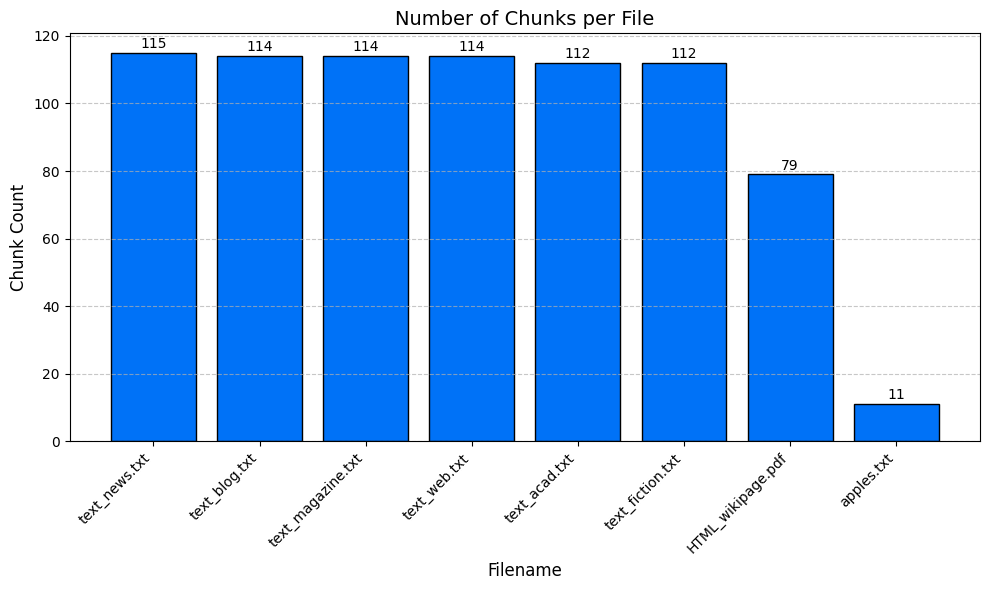

In [18]:
# Count chunks per file
chunk_counts = Counter(chunk['filename'] for chunk in chunks)

# Sort by number of chunks descending
chunk_counts = dict(sorted(chunk_counts.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(chunk_counts.keys(), chunk_counts.values(), color='#0072F7', edgecolor='black')
plt.title('Number of Chunks per File', fontsize=14)
plt.xlabel('Filename', fontsize=12)
plt.ylabel('Chunk Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of bars
for i, count in enumerate(chunk_counts.values()):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Step 3: Associating Metadata

#### Functional Code

In [9]:
for chunk in chunks:
    chunk["metadata"] = file_contents[chunk["filename"]]["metadata"]

In [10]:
metadata = random_chunk()["metadata"]
print("Sample metadata:")
for key, value in metadata.items():
    print(f"{key}: {value}")


Sample metadata:
type: file
id: 1953001153898
file_version: <Box FileVersion - 2154938521898>
sequence_id: 1
etag: 1
sha1: 77b08814cf1f787e67acca74f40113f6c46c5118
name: text_fiction.txt
description: 
size: 6413358
path_collection: {'total_count': 2, 'entries': [<Box Folder - 0 (All Files)>, <Box Folder - 335468550588 (RAG_Ingestion_Demo)>]}
created_at: 2025-08-12T11:03:22-07:00
modified_at: 2025-08-12T11:03:33-07:00
trashed_at: None
purged_at: None
content_created_at: 2020-01-10T22:01:06-08:00
content_modified_at: 2020-01-10T22:01:06-08:00
created_by: <Box User - 44476300706 (Sam Altman)>
modified_by: <Box User - 44476300706 (Sam Altman)>
owned_by: <Box User - 43951904830 (Nikita X-One)>
shared_link: None
parent: <Box Folder - 335468550588 (RAG_Ingestion_Demo)>
item_status: active


#### Visualization

/var/folders/dz/ck8cqz595z17qxftnxfsw0jc0000gn/T/ipykernel_9472/453720946.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')


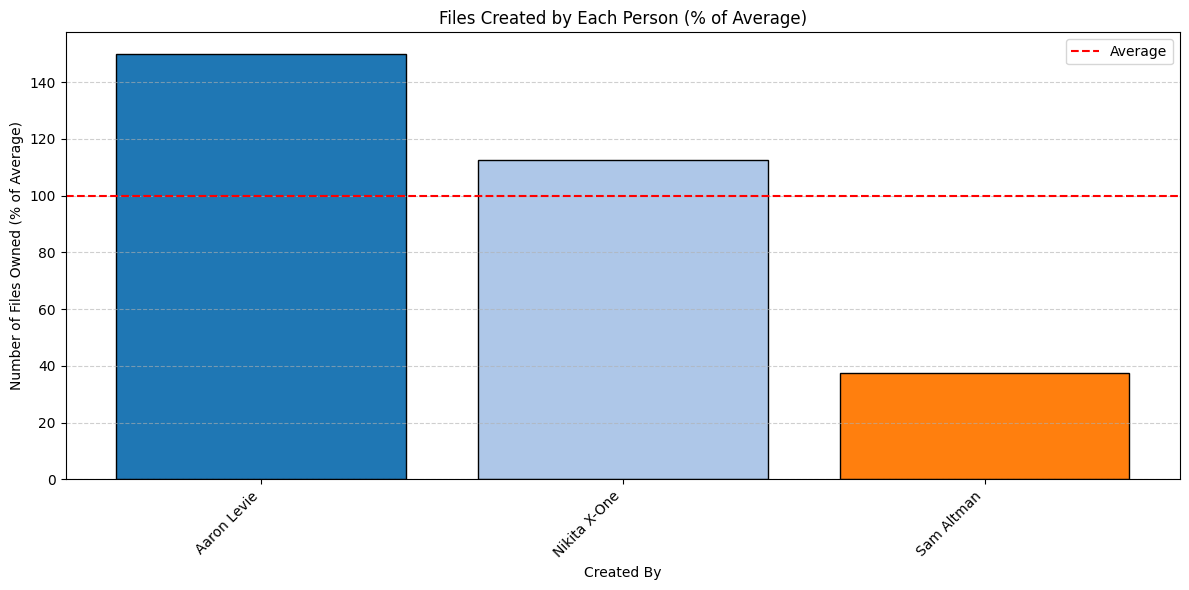

In [11]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import re
import matplotlib.cm as cm

# Count files per owner
owners = []
for info in file_contents.values():
    owner_info = info.get('metadata', {}).get('created_by')
    if owner_info:
        if isinstance(owner_info, dict):
            owner_name = owner_info.get('name') or owner_info.get('login') or "Unknown"
        else:
            owner_name = str(owner_info)
        # Safely get first parentheses match or fallback
        match = re.search(r'\((.*?)\)', owner_name)
        owners.append(match.group(1) if match else owner_name)
    else:
        owners.append("Unknown")

owner_counts = Counter(owners)
owner_counts = dict(sorted(owner_counts.items(), key=lambda x: x[1], reverse=True))

avg_files = np.mean(list(owner_counts.values()))
percent_of_avg = {owner: (count / avg_files) * 100 for owner, count in owner_counts.items()}

# Generate colors for each bar
cmap = cm.get_cmap('tab20')
colors = [cmap(i % 20) for i in range(len(percent_of_avg))]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(percent_of_avg.keys(), percent_of_avg.values(), color=colors, edgecolor='black')
plt.axhline(100, color='red', linestyle='--', label='Average')
plt.ylabel('Number of Files Owned (% of Average)')
plt.xlabel('Created By')
plt.title('Files Created by Each Person (% of Average)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Step 4: Embedding Chunks

#### Functional Code

In [ ]:
from openai import OpenAI

# Fill with your credentials.
OPEN_API_KEY = "..."

OAIclient = OpenAI(
  api_key=OPEN_API_KEY,
)

def get_embedding(texts):
    response = OAIclient.embeddings.create(
        input=texts,
        model="text-embedding-3-small",
        dimensions=1024 
    )
    embeddings = [data.embedding for data in response.data]
    return embeddings
    
MAX_CHUNKS_PER_BATCH = 1800

texts = [chunk["text"] for chunk in chunks]
batches = [texts[i : i + MAX_CHUNKS_PER_BATCH] for i in range(0, len(texts), MAX_CHUNKS_PER_BATCH)]

embedding_vectors = []
for batch in batches:
    batch_embeddings = get_embedding(batch)
    embedding_vectors.extend(batch_embeddings)

for i in range(len(chunks)):
    chunks[i]["embedding"] = embedding_vectors[i]

In [13]:
print(f"Sample embedding vector: {chunks[0]["embedding"]}")

Sample embedding vector: [0.0007435178267769516, -0.0405142568051815, 0.003131050383672118, 0.05716769024729729, 0.025717269629240036, -0.034398894757032394, -0.009862381964921951, -0.020311729982495308, -0.001010979525744915, 0.02706865593791008, 0.001846210565418005, -0.02663184329867363, -0.028447341173887253, -0.01376638375222683, 0.006832003127783537, -0.027887675911188126, -0.010824732482433319, 0.048677168786525726, 0.014660482294857502, 0.019001295790076256, 0.05383700132369995, 0.022932598367333412, 0.008620199747383595, 0.001759189646691084, 0.008176563307642937, -0.06071678176522255, -0.03729277104139328, 0.05290877819061279, -0.026126781478524208, -0.07109105587005615, -0.0023273855913430452, -0.015356650575995445, -0.027109606191515923, -0.0044431909918785095, -0.025621717795729637, -0.009370969608426094, 0.031996432691812515, -0.013957488350570202, -0.006814939901232719, 0.009452871046960354, -0.0174451544880867, -0.00892050750553608, 0.028310837224125862, 0.0475851409137

#### Visualization
Reduced dimensionality clustering.

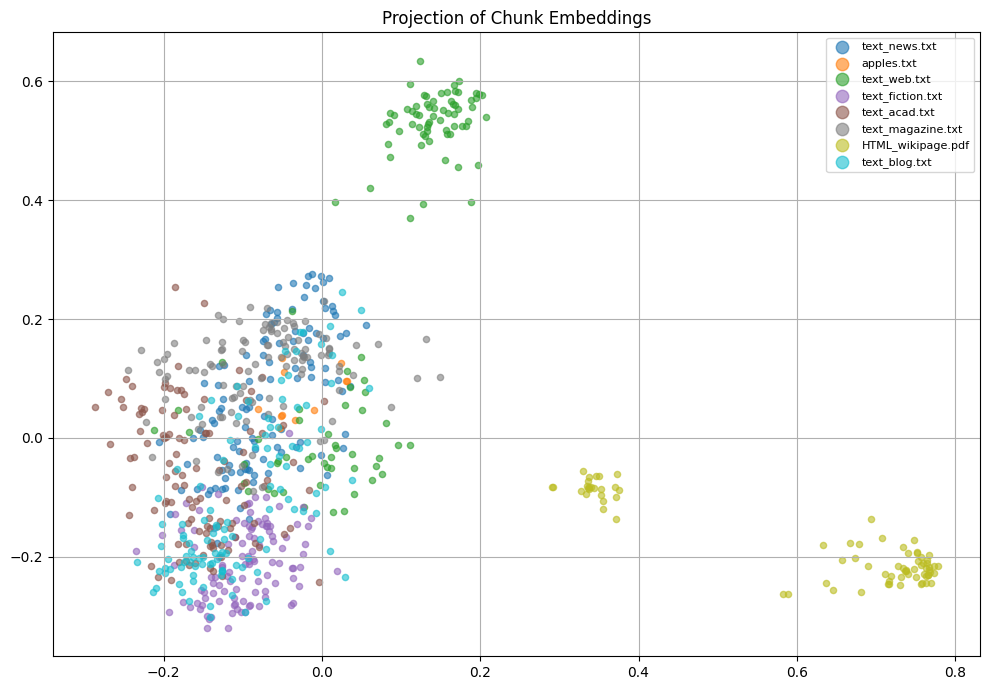

In [14]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib

# Collect embeddings and filenames
embeddings = np.array([chunk["embedding"] for chunk in chunks])
filenames = [chunk["filename"] for chunk in chunks]

# PCA reduction to 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# Unique filenames and color mapping
unique_files = list(set(filenames))
cmap = matplotlib.colormaps.get_cmap('tab10').resampled(len(unique_files))
color_map = {fname: cmap(i) for i, fname in enumerate(unique_files)}

# Plot
plt.figure(figsize=(10, 7))
for fname in unique_files:
    idxs = [i for i, f in enumerate(filenames) if f == fname]
    plt.scatter(
        reduced[idxs, 0], 
        reduced[idxs, 1], 
        label=fname, 
        color=color_map[fname], 
        alpha=0.6, 
        s=20
    )

plt.title("Projection of Chunk Embeddings")
plt.legend(markerscale=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

### Step 5: Indexing

#### Functional Code

In [ ]:
import hnswlib
import numpy as np

embeddings = np.array([chunk["embedding"] for chunk in chunks])
N, D = embeddings.shape

# Initialize HNSW index
p = hnswlib.Index(space='cosine', dim=D)  # or 'l2' for Euclidean
p.init_index(max_elements=N, ef_construction=200, M=16)

# Add embeddings
p.add_items(embeddings)

# Set ef (controls recall/speed)
p.set_ef(50)

# Build the graph: for each node, get its neighbors
hnsw_graph = {}
for i in range(N):
    # k = number of neighbors to retrieve (including the node itself)
    labels, distances = p.knn_query(embeddings[i], k=3)
    # Exclude self from neighbors
    neighbors = [label for label in labels[0] if label != i]
    hnsw_graph[i] = neighbors

#### Visualization

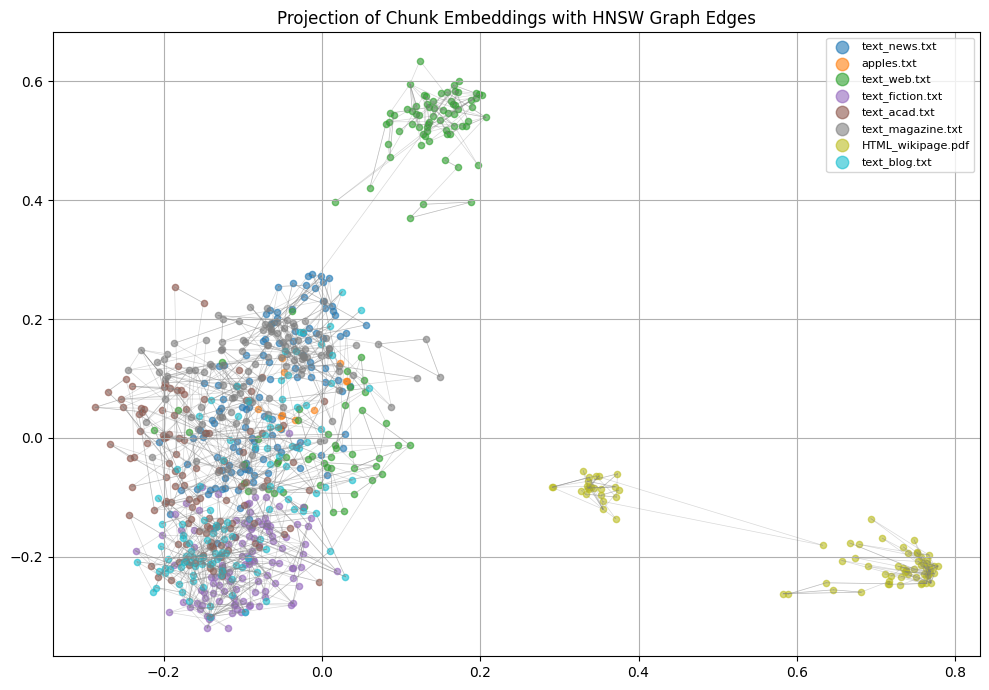

In [16]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib

# embeddings and filenames as before
embeddings = np.array([chunk["embedding"] for chunk in chunks])
filenames = [chunk["filename"] for chunk in chunks]

# Your HNSW graph: dict[node] = list of neighbor nodes
# e.g., hnsw_graph = {0: [5, 10], 1: [0, 3], ...}

# PCA reduction to 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# Unique filenames and color mapping
unique_files = list(set(filenames))
cmap = matplotlib.colormaps.get_cmap('tab10').resampled(len(unique_files))
color_map = {fname: cmap(i) for i, fname in enumerate(unique_files)}

plt.figure(figsize=(10, 7))

# Plot points by file with colors
for fname in unique_files:
    idxs = [i for i, f in enumerate(filenames) if f == fname]
    plt.scatter(
        reduced[idxs, 0],
        reduced[idxs, 1],
        label=fname,
        color=color_map[fname],
        alpha=0.6,
        s=20,
    )

# Draw HNSW graph edges
for node, neighbors in hnsw_graph.items():
    for neighbor in neighbors:
        x_coords = [reduced[node, 0], reduced[neighbor, 0]]
        y_coords = [reduced[node, 1], reduced[neighbor, 1]]
        plt.plot(x_coords, y_coords, color='gray', alpha=0.3, linewidth=0.5)

plt.title("Projection of Chunk Embeddings with HNSW Graph Edges")
plt.legend(markerscale=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

